### Notebook setup

In [38]:
%matplotlib inline
%autosave 30

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_rows', 10)
np.random.seed(42)

Autosaving every 30 seconds


### Datasets

| Dataset             | Comment                                           | Size (clicks/size)  |
|---------------------|---------------------------------------------------|---------------------|
| train.csv           | the training set                                  | 57.537.506 / 2.5 GB |
| train_sample.csv    | sample of training set                            | 100.000 / 3.9 MB |
| test.csv            | the test set                                      | 18.790.469 / 824 MB |
| test_supplement.csv | larger test set, subset used for Kaggle evaluation | 57.537.505 / 2.5GB  |


Every click record has following associated fields:
- click_time: timestamp of click (UTC)
- ip: ip address of click
- device: device type of user mobile phone
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- app: app id for marketing

Training data contains two additional fields:
- is_attributed: was app downloaded, to be predicted
- attributed_time: time of app download

For the given click data, the goal is to output the probability that the user will download the app.


Read train and test sets for local modeling and evaluation.

In [ ]:
def read_dataset(path, nrows=None):
    df = pd.read_csv(path, nrows=nrows)
    df['click_time'] = pd.to_datetime(df['click_time'])
    df = df.set_index('click_time')
    df.sort_index(inplace=True)
    
    return df

dataset_train = read_dataset('data/mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv')
dataset_test = read_dataset('data/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv', nrows=1000000)
dataset_test_all = read_dataset('data/test.csv')

### Data exploration

In [ ]:
dataset_train.describe()

In [ ]:
ser = dataset_train.nunique()
pd.DataFrame({'attribute':ser.index, 'unique values':ser.values})

In [ ]:
dataset_train.hist(bins=20, figsize=(10,10));

Distribution of `is_attributed` feature shows heavily unbalanced dataset towards no download cases.

In [ ]:
corr = dataset_train.corr()
corr.style.background_gradient()

In [ ]:
dataset_train[(dataset_train.is_attributed == 1)].hist(bins=20, figsize=(10,10));

In [ ]:
top_apps = dataset_train.groupby(['ip'])['is_attributed'].agg(
    {"is_attributed": sum}).sort_values(
    "is_attributed", ascending=False).head(10).reset_index()
top_apps

In [ ]:
top_apps = dataset_train.groupby(['app','channel'])['is_attributed'].agg(
    {"is_attributed": sum}).sort_values(
    "is_attributed", ascending=False).head(10).reset_index()
top_apps

In [ ]:
dataset_train.apply(lambda x: 1 if x['is_attributed'] == 1 else 0, axis=1).plot(figsize=(20, 5));

In [ ]:
dataset_train.apply(lambda x: 1 if x['app'] == 19 else 0, axis=1).plot(figsize=(20, 5));

In [ ]:
dataset_train.apply(lambda x: 1 if x['channel'] == 213 and x['app'] == 19 else 0, axis=1).plot(figsize=(20, 5));

### Benchmark models

For benchmark we will consider two models, one outputing constant value and second using random value from uniform distribution. Both will be evaluated on test set and the one with higher score will be used as baseline.

In [ ]:
dataset_test.head()

In [ ]:
benchmark_const = dataset_test_all[['click_id']].copy()
benchmark_const['is_attributed'] = 0
display(benchmark_const)

In [ ]:
benchmark_rand = dataset_test_all[['click_id']].copy()
benchmark_rand['is_attributed'] = np.random.uniform(size=len(benchmark_rand))
display(benchmark_rand)

Constant model that predicts no app download scores 0.5 on Kaggle evaluator. Random model that uses uniform distribution scores 0.4995 as private score (82% of test data) and 0.5003 as public score (18% of the test data). One approach to this problem is done by [Elior Tal](https://rpubs.com/el16/410747) and his solution scores 0.825 on a subset of the test set. In his work he compares performance of random forest and boosting algorithms. We will use this as a benchmark model as it is well documented and scores better than our initial baseline models. Additionally we will use existing Kaggle solutions on the [leaderboard](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/leaderboard ) as a supporting benchmark.

### Data preprocessing

* Extract hour of the day
* For each attribute extract duration since last click with that attribute
* Remove attributes: attributed_time, click_time, is_attributed

In [ ]:
from sklearn import preprocessing

def prepare_column(job):
    df = job['df']
    col = job['feat']
    
    print ('Preparing column: ', col)
    def calculate_last(row, attr, attr_map):
        attr_val = row[attr]
        if attr_val in attr_map:
            st = attr_map.get(attr_val)
            et = row['click_time']
            val = min((et - st).total_seconds(), 86400)
        else:
            val = 86400
        attr_map[attr_val] = row['click_time']
        return val

    new_col = 'last_'+col
    df[new_col] = df.apply(calculate_last, axis=1, attr=col, attr_map={})
    x = df[[new_col]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df[new_col] = x_scaled
    return df[new_col]

def prepare_dataset(df):
    df['hour'] = df.index.hour
    df['click_time'] = df.index
    pool = mp.Pool(maxtasksperchild=1000)

    jobs = [{'df':df,'feat':feat} for feat in ['ip', 'app', 'os', 'channel', 'device']]
    with tqdm(total=len(jobs), desc="Preparing features") as pbar:
        for feat in pool.imap(prepare_column, jobs):
            df = pd.concat([df, feat], axis=1)
            pbar.update()
            
    pool.close()
    pool.join()

    return df.drop(labels=['is_attributed', 'attributed_time', 'click_time'], axis=1, errors='ignore')

In [27]:
print('Preparing train dataset')
train_y = dataset_train['is_attributed']
%time train_X = prepare_dataset(dataset_train)

print('Preparing test dataset')
test_y = dataset_test['is_attributed']
%time test_X = prepare_dataset(dataset_test)

Preparing train dataset


Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 1.69 s, sys: 219 ms, total: 1.91 s
Wall time: 22.5 s
Preparing test dataset


Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 6.98 s, sys: 1.1 s, total: 8.08 s
Wall time: 3min 40s


In [ ]:
train_X['last_app'].plot(figsize=(20, 5));

In [ ]:
train_X.tail()

Additional features to be considered adding:
- for each attribute number of clicks in previous N minutes with same attribute
value

### Model training

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression confusion matrix:


,0,1
0,998305,2
1,1693,0


GaussianNB(priors=None)

GaussianNB confusion matrix:


,0,1
0,994224,4083
1,1482,211


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

DecisionTreeClassifier confusion matrix:


,0,1
0,996123,2184
1,1245,448


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

GradientBoostingClassifier confusion matrix:


,0,1
0,998001,306
1,1572,121


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier confusion matrix:


,0,1
0,997829,478
1,1576,117


,auc,clf
0,0.562072,LogisticRegression
2,0.631216,DecisionTreeClassifier
4,0.736183,RandomForestClassifier
1,0.762397,GaussianNB
3,0.843181,GradientBoostingClassifier


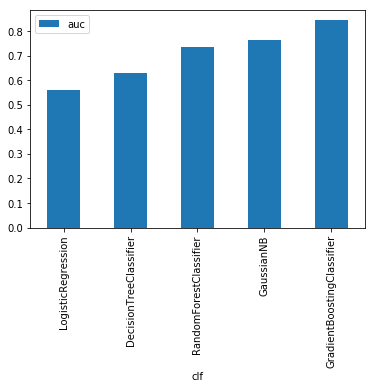

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

def evaluate_model(clf, tstX=test_X, tsty=test_y):
    predicted_proba_y = clf.predict_proba(tstX)[:,1]
    predicted_y = clf.predict(tstX)
    clf_name = str(clf).split('(')[0]
    display(clf)
    print(clf_name + ' confusion matrix:')
    display(pd.DataFrame(confusion_matrix(tsty, predicted_y)))
    return [{'clf': clf_name,
            'auc': roc_auc_score(tsty, predicted_proba_y)}]

results = []
for clf in [LogisticRegression(random_state=42), 
            GaussianNB(), 
            tree.DecisionTreeClassifier(random_state=42),
            GradientBoostingClassifier(random_state=42),
            RandomForestClassifier(random_state=42)]:
    clf.fit(train_X, train_y)
    results += evaluate_model(clf)
    
results = pd.DataFrame(results).sort_values(by=['auc'])

display(results)
results.plot.bar(x='clf');

In [ ]:
%%time

# https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.externals import joblib

def optimize_model(estimator, params, cv):
    scorer = make_scorer(roc_auc_score)
    gs = GridSearchCV(estimator=estimator, param_grid=params, 
                      scoring=scorer, cv=cv, verbose=3,
                      n_jobs=-1)
    return gs.fit(train_X, train_y)

cv = StratifiedKFold(n_splits=5, shuffle=True)
model = optimize_model(GradientBoostingClassifier(random_state=42), {
        'loss' : ['deviance', 'exponential'],
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [50, 100, 200],
    }, cv=cv)

joblib.dump(model, 'final_model.joblib') 
display(pd.DataFrame(evaluate_model(model)))

In [ ]:
model.estimator

### Sensitivity analysis

In [44]:
dataset_test_sens = dataset_test.copy()

time_delta = pd.Series([ pd.Timedelta(minutes=np.random.randint(-120, 121)) for i in range(len(test_X)) ])
dataset_test_sens.index = dataset_test_sens.index + time_delta
dataset_test_sens['click_time'] = dataset_test_sens.index
dataset_test_sens.sort_index(inplace=True)

In [45]:
display(dataset_test_sens.head())
display(dataset_test.head())

,ip,app,device,os,channel,attributed_time,is_attributed,hour,click_time
2017-11-06 12:52:51,191759,3,1,13,379,NaN,0,14,2017-11-06 12:52:51
2017-11-06 12:56:08,161007,3,1,13,379,NaN,0,14,2017-11-06 12:56:08
2017-11-06 12:59:43,73503,3,1,18,379,NaN,0,14,2017-11-06 12:59:43
2017-11-06 13:03:36,129614,3,1,20,379,NaN,0,14,2017-11-06 13:03:36
2017-11-06 13:03:44,103022,3,1,23,379,NaN,0,14,2017-11-06 13:03:44


,ip,app,device,os,channel,attributed_time,is_attributed,hour,click_time
click_time,,,,,,,,,
2017-11-06 14:32:21,83230,3,1,13,379,NaN,0,14,2017-11-06 14:32:21
2017-11-06 14:33:34,17357,3,1,19,379,NaN,0,14,2017-11-06 14:33:34
2017-11-06 14:34:12,35810,3,1,13,379,NaN,0,14,2017-11-06 14:34:12
2017-11-06 14:34:52,45745,14,1,13,478,NaN,0,14,2017-11-06 14:34:52
2017-11-06 14:35:08,161007,3,1,13,379,NaN,0,14,2017-11-06 14:35:08


In [46]:
print('Preparing modified test dataset')
test_sens_y = dataset_test_sens['is_attributed']
%time test_sens_X = prepare_dataset(dataset_test_sens)

test_sens_X.head()

Preparing modified test dataset


Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 6.21 s, sys: 946 ms, total: 7.15 s
Wall time: 3min 54s


,ip,app,device,os,channel,hour,last_ip,last_app,last_os,last_channel,last_device
2017-11-06 12:52:51,191759,3,1,13,379,12,1.0,1.000000,1.00000,1.000000,1.000000
2017-11-06 12:56:08,161007,3,1,13,379,12,1.0,0.002280,0.00228,0.002280,0.002280
2017-11-06 12:59:43,73503,3,1,18,379,12,1.0,0.002488,1.00000,0.002488,0.002488
2017-11-06 13:03:36,129614,3,1,20,379,13,1.0,0.002697,1.00000,0.002697,0.002697
2017-11-06 13:03:44,103022,3,1,23,379,13,1.0,0.000093,1.00000,0.000093,0.000093


In [49]:
from sklearn.externals import joblib

model = joblib.load('final_model.joblib')

display(pd.DataFrame(evaluate_model(model, test_sens_X, test_sens_y)))

/home/dkomlen/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/dkomlen/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/dkomlen/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/dkomlen/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.2 when using versi

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=3)

GridSearchCV confusion matrix:


,0,1
0,997626,681
1,1518,175


,auc,clf
0,0.870602,GridSearchCV


### Model evaluation

In [27]:
test_all_ids = dataset_test_all['click_id']
%time test_all_X = prepare_dataset(dataset_test_all.drop('click_id', axis=1))

Preparing column:  ip
Preparing column:  app
Preparing column:  os
Preparing column:  channel
Preparing column:  device

CPU times: user 20.4 s, sys: 49.7 s, total: 1min 10s
Wall time: 49min 50s


In [28]:
from sklearn.externals import joblib

clf = joblib.load('final_model.joblib') 
test_y = clf.predict_proba(test_all_X)

In [29]:
test_result = pd.DataFrame(test_y)

In [30]:
test_result = pd.DataFrame(test_y[:,1], columns=['is_attributed'])
test_result['click_id'] = test_all_ids.values

test_result.to_csv('data/test_result.csv.gz',compression='gzip', index=False)

Kaggle test results:
- private score: 0.8919713
- public score: 0.8888370